#PACKAGES

In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
import os
import pandas as pd
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
import zipfile
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from google.colab import files
from tensorflow.keras.preprocessing import image

#EXPLORE DATA

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Color Images.zip to Color Images (1).zip


In [21]:
!rm -rf machine-learning
!git clone https://github.com/C242-PS126-Team/machine-learning.git
!ls "machine-learning/dataset/Color Images/"
# Dataset untuk digunakan dalam model
dataset_path = "/content/machine-learning/dataset/Color Images/"

Cloning into 'machine-learning'...
remote: Enumerating objects: 3315, done.
remote: Counting objects: 100% (561/561), done.
remote: Compressing objects: 100% (516/516), done.
remote: Total 3315 (delta 303), reused 180 (delta 45), pack-reused 2754 (from 1)
Receiving objects: 100% (3315/3315), 18.56 MiB | 28.45 MiB/s, done.
Resolving deltas: 100% (923/923), done.
Train  Valid


In [3]:
zip_file_name = 'Color Images (1).zip'

extract_to = '/content/Color_Images'
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [27]:
# Load and preprocess datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/machine-learning/dataset/Color Images/Train",
    seed=0,
    image_size=(256, 256),
    batch_size=32,
    labels='inferred',
    label_mode='int'
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/machine-learning/dataset/Color Images/Valid",
    seed=0,
    image_size=(256, 256),
    batch_size=16,
    labels='inferred',
    label_mode='int'
)
num_classes = len(train_ds.class_names)

Found 1105 files belonging to 11 classes.
Found 566 files belonging to 11 classes.


In [28]:
# Augmentasi Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "/content/machine-learning/dataset/Color Images/Train",
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    "/content/machine-learning/dataset/Color Images/Valid",
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical'
)

Found 1105 images belonging to 11 classes.
Found 566 images belonging to 11 classes.


In [29]:
# Fungsi untuk augmentasi gambar
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

train_ds = train_ds.map(augment_image).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.map(augment_image).prefetch(tf.data.AUTOTUNE)

#FREATURE ENGINEERING

In [30]:
def seed_everything(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything()

def normalize(image):
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image

STRATEGY = tf.distribute.MirroredStrategy()
print("Number of devices: ", STRATEGY.num_replicas_in_sync)

Number of devices:  1


In [31]:
# Model dengan feature extraction dari EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Mengurangi dimensi spasial

# Menambahkan lapisan Dense untuk klasifikasi
x = Dense(128, activation='relu')(x)
x = Dense(11, activation='softmax')(x)

final_model = Model(inputs=base_model.input, outputs=x)
final_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 256, 256, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,214,958 (16.08 MB)

 Trainable params: 4,172,935 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [32]:
def get_model():
    INPUT_SHAPE = (256, 256, 3)

    # Membuat model menggunakan EfficientNetB0 sebagai feature extractor
    with tf.distribute.MirroredStrategy().scope():  # Jika menggunakan distribusi
        # Membuat input
        image = Input(INPUT_SHAPE, name='image', dtype=tf.uint8)

        # Normalisasi input gambar
        image_norm = tf.keras.applications.efficientnet.preprocess_input(image)

        # Menggunakan EfficientNetB0 dengan bobot dari ImageNet
        x = EfficientNetB0(weights='imagenet', include_top=False, input_shape=[256, 256, 3])(image_norm)

        # Global Average Pooling
        x = GlobalAveragePooling2D()(x)

        # Dropout untuk mengurangi overfitting
        x = Dropout(0.5)(x)

        # Lapisan output dengan 10 kelas dan fungsi aktivasi softmax
        outputs = Dense(num_classes, activation='softmax')(x)

        # Menggunakan optimizer AdamW dengan weight decay
        optimizer = Adam(learning_rate=0.001, weight_decay=1e-4)

        # Loss dan metric untuk multi-class classification
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
        metrics = [tf.keras.metrics.AUC(), tf.keras.metrics.CategoricalAccuracy()]

        # Membuat dan mengkompilasi model
        model = Model(inputs=image, outputs=outputs)
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        return model

#Train the Model

In [33]:
STRATEGY = tf.distribute.MirroredStrategy()
with STRATEGY.scope():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(11, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    verbose=1,
    callbacks=[lr_callback]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.4237 - loss: 23.2885 - val_accuracy: 0.6254 - val_loss: 1.4923 - learning_rate: 0.0010
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.6573 - loss: 1.4409 - val_accuracy: 0.6608 - val_loss: 0.9409 - learning_rate: 0.0010
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.6552 - loss: 1.2289 - val_accuracy: 0.6873 - val_loss: 1.2802 - learning_rate: 0.0010
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.6591 - loss: 1.1085 - val_accuracy: 0.5830 - val_loss: 1.0404 - learning_rate: 0.0010
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.6390 - loss: 1.0991 - val_accuracy: 0.7191 - val_loss: 0.9060 - learning_rate: 0.0010
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.6970 - loss: 0.8908 - val_accuracy: 0.5671 - val_loss: 1.3543 - learning_rate: 0.0010
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.6086 - loss: 1.3278 - val_ac

#Plotting the training and validation accuracy and loss

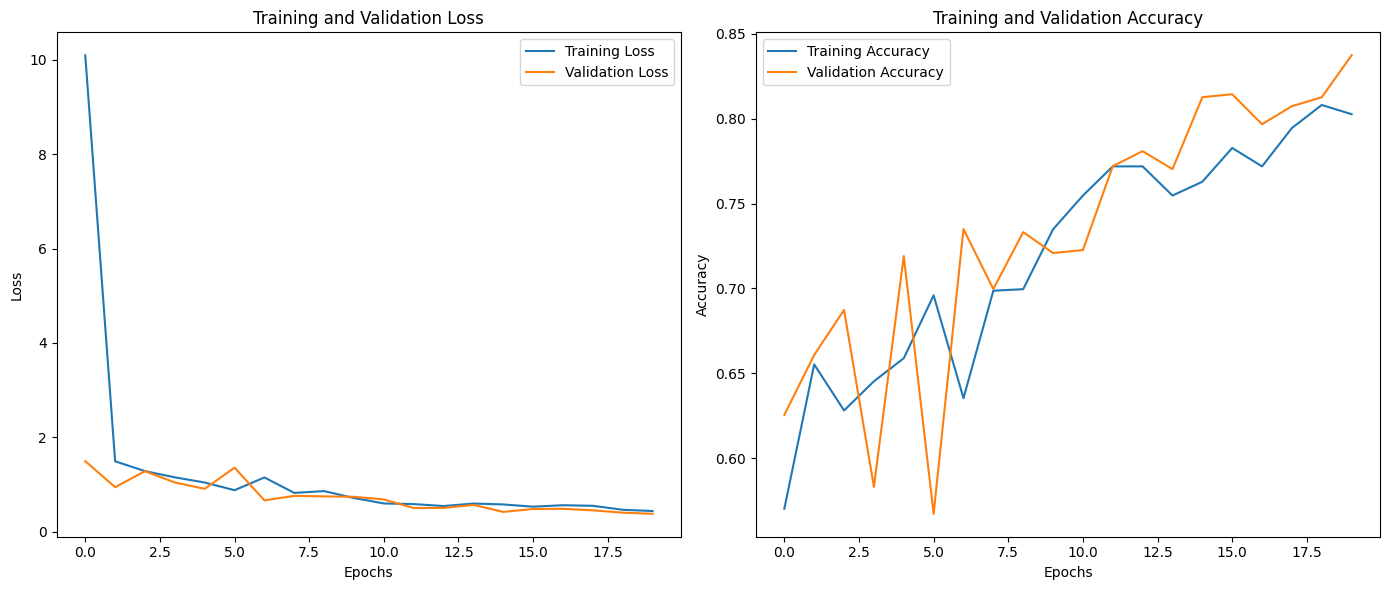

In [34]:
# Get training and validation accuracy and loss from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create figure for plotting
plt.figure(figsize=(14, 6))

# Plot the loss
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

#Evaluation Model

In [35]:
loss, accuracy = model.evaluate(valid_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 383ms/step - accuracy: 0.8334 - loss: 0.3928
Validation Accuracy: 83.75%
Validation Loss: 0.3764


#Test Predict Image

In [52]:
url = "https://raw.githubusercontent.com/C242-PS126-Team/machine-learning/main/dataset/Criteria_color.xlsx"
criteria_color = pd.read_excel(url)
color_dict = criteria_color.set_index('Color Name').to_dict(orient='index')

# Fungsi untuk prediksi dan menampilkan warna beserta informasi lainnya
def predict_color(uploaded_file, model, class_indices, color_dict):
    img = image.load_img(uploaded_file, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    class_names = list(class_indices.keys())
    predicted_class = class_names[np.argmax(predictions)]
    color_info = color_dict.get(predicted_class, None)

    if color_info:
        color_details = f"RGB: {color_info['RGB']}, " \
                        f"Hue (HSL/HSV): {color_info['Hue (HSL/HSV)']}, " \
                        f"Saturation (HSL): {color_info['Saturation (HSL)']}, " \
                        f"Light (HSL): {color_info['Light (HSL)']}, " \
                        f"Saturation (HSV): {color_info['Saturation (HSV)']}, " \
                        f"Value (HSV): {color_info['Value (HSV)']}"
    else:
        color_details = "Informasi warna tidak ditemukan."

    return predicted_class, color_details

while True:
    print("Silakan scan warna untuk deteksi: ")
    uploaded = files.upload()

    if uploaded:
        for file_name in uploaded.keys():
            print(f"Processing file: {file_name}")

            class_indices = train_generator.class_indices

            predicted_class, color_details = predict_color(file_name, model, class_indices, color_dict)
            print(f"The predicted color is: {predicted_class}")
            print(f"Details: {color_details}")

Silakan scan warna untuk deteksi: 


Saving Coquelicot.png to Coquelicot (1).png
Processing file: Coquelicot (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
The predicted color is: Red
Details: RGB: Red: 80% - 100%; Green: 0% - 20%; Blue: 0% - 20%, Hue (HSL/HSV): 0° - 30°, Saturation (HSL): 80% - 100%, Light (HSL): 30% - 60%, Saturation (HSV): 8% - 100%, Value (HSV): 70% - 100%
Silakan scan warna untuk deteksi: 


Saving Green_(pigment).png to Green_(pigment) (1).png
Processing file: Green_(pigment) (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
The predicted color is: Green
Details: RGB: Red: 0% - 30%; Green: 70% - 100%; Blue: 0% - 30%, Hue (HSL/HSV): 90° - 150°, Saturation (HSL): 60% - 100%, Light (HSL): 30% - 60%, Saturation (HSV): 60% - 100%, Value (HSV): 70% - 100%
Silakan scan warna untuk deteksi: 


KeyboardInterrupt: 

#Save The Model

In [15]:
model.save('true_color_model.h5')

In [16]:
from google.colab import files
files.download('true_color_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>